In [1]:

# for basic operations
import numpy as np 
import pandas as pd 
from scipy import stats
from sklearn.model_selection import train_test_split

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# for preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import f1_score, matthews_corrcoef,confusion_matrix,plot_confusion_matrix
# feature importance
from sklearn.inspection import permutation_importance


# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



In [2]:
class FileController:
    def readCsv(self,path):
        return pd.read_csv(path)      
    

In [3]:
class PreprocessController:
    def nullKnnImputer(self,df_train,df_test):
        imputer = KNNImputer()
        imputer.fit(df_train)
        return pd.DataFrame(imputer.transform(df_train), columns = df_train.columns),pd.DataFrame(imputer.transform(df_test), columns = df_test.columns)

    def dropCol(self,df_train,df_test,col):
        return df_train.drop(col,axis=1),df_test.drop(col,axis=1)
        

In [4]:

class EdaController:
    '''
    데이터 프레임을 설명에 쓰이는 클래스.(does not modify df)
    '''
        
    def summary(self,df, pred=None):
        obs = df.shape[0]
        Types = df.dtypes
        Counts = df.apply(lambda x: x.count())
        Min = df.min()
        Max = df.max()
        Uniques = df.apply(lambda x: x.unique().shape[0])
        Nulls = df.apply(lambda x: x.isnull().sum())
        print('Data shape:', df.shape)

        if pred is None:
            cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
            st = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

        st.columns = cols
        print('___________________________\nData Types:')
        print(st.Types.value_counts())
        print('___________________________')
        return st
    
    def imbalancedVisual(self,ser):
        labels = ['Pass', 'Fail']
        size = ser.value_counts()
        colors = ['blue', 'green']
        explode = [0, 0.1]

        plt.style.use('seaborn-deep')
        plt.rcParams['figure.figsize'] = (8, 8)
        plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
        plt.axis('off')
        plt.title('Target: Pass or Fail', fontsize = 20)
        plt.legend()
        plt.show()
        # plt.bar(2,ser.value_counts())
        ser.value_counts().plot(kind="bar", color=['b','g'])
        plt.show()
    
    def checkUniqueValueColWithRawData(self,df,fillNull=True):
        temp = df.apply(lambda x: x.unique().shape[0])
        temp2 = df.fillna(method='ffill').apply(lambda x: x.unique().shape[0])
        print('1 unique vaule:',len(temp[temp.isin([1])]),'개')
        print('1 unique vaule + null :',len(temp2[temp2.isin([1])]),'개')

        if fillNull:
            return list(temp2[temp2.isin([1])].index)
        else:
            return list(temp[temp.isin([1])].index)
         


    def checkNull(self,df,percent=None):
        '''
        return list of index which has greater missing percentage if percent value is passed. 
        '''
        missPercentTable = df.isnull().sum()/df.shape[0]*100
        for n in range(10,100,10):
            print(f'missing {n}~{n+10}%: {len([i for i,p in enumerate(missPercentTable) if p>=n and p<n+10 ])}개')
        if percent:
            return [i for i,p in missPercentTable.iteritems() if p<percent and p>=10 ],[i for i,p in missPercentTable.iteritems() if p>=percent ]

    def correlation(self,dataset, threshold):
        col_corr = set()  # Set of all the names of correlated columns
        corr_matrix = dataset.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    col_corr.add(colname)
        return col_corr
        
    

In [5]:
class ModelingController:

    def logisticEvaluate(self,train_df, test_df, train_target, test_target):

        model_order = ['Logistic Regression','RandomForest']
        lr_score = []
        rf_score = []


        lr_coef = []
        rf_coef = []

    
        scaler = RobustScaler()
        scaler.fit(train_df)
        train_std = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
        test_std = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

        y_train_true = train_target.values.ravel()
        y_test_true = test_target.values.ravel()

        logreg = LogisticRegression()
        rf = RandomForestClassifier(n_estimators=5,random_state=0,max_depth=12,n_jobs=-1)


        for i,clf in enumerate([logreg,rf]):
            clf.fit(train_std, train_target.values.ravel())

            y_train_pred = clf.predict(train_std)
            y_test_pred = clf.predict(test_std)

            f1score_train = f1_score(y_train_true, y_train_pred, average='micro')
            f1score_test = f1_score(y_test_true, y_test_pred, average='micro')
            mccscore_train=matthews_corrcoef(y_train_true, y_train_pred)
            mccscore_test=matthews_corrcoef(y_test_true, y_test_pred)
            cm =confusion_matrix(y_test_true,y_test_pred)
            tn,fp,fn,tp = cm.ravel()
            fpr = fp/(fp+tn)
            sns.heatmap(cm,annot=True,cmap='Blues')
            plt.show()
            if i ==0:
                lr_score.extend([f1score_train,f1score_test,mccscore_train,mccscore_test,fpr])
                t1_df = pd.DataFrame([list(map(abs,clf.coef_))[0],clf.coef_[0]],columns=list(train_std.columns))
                t1_df = t1_df.T.sort_values(by=0,ascending=False).drop([0],axis=1)

               

            else:
                rf_score.extend([f1score_train,f1score_test,mccscore_train,mccscore_test,fpr])
 
                imp = clf.feature_importances_

                t3_df = pd.DataFrame([list(map(abs,imp)),imp],columns=list(train_std.columns))
                t3_df = t3_df.T.sort_values(by=0,ascending=False).drop([0],axis=1)

            del y_train_pred, y_test_pred
        imp_result = pd.DataFrame([t1_df.index,t3_df.index],index=model_order).transpose()
        # display(imp_result)

        
        result = pd.DataFrame([lr_score,rf_score],index=model_order,columns=['f1_train','f1_test','mcc_train','mcc_test','fpr'])
        display(result)

        return imp_result ,result

# Initailize Class

In [6]:
#class initialize
fController = FileController()
eController = EdaController()
pController = PreprocessController()
mController = ModelingController()

# Load Data Frame & Split Data

In [41]:
# load csv file
rawData = fController.readCsv('./uci-secom.csv')

In [42]:
X = rawData.iloc[:,:-1]
y = rawData.iloc[:,-1]
# 종속변수 1,0으로 변환
y=y.replace(1,0)
y=y.replace(-1,1)
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=0)

# EDA

# 1. Summary

In [43]:
summaryTable = eController.summary(df=rawData)
display(summaryTable)

Data shape: (1567, 592)
___________________________
Data Types:
float64    590
int64        1
object       1
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
0,float64,1561,1521,6,2743.24,3356.35
1,float64,1560,1505,7,2158.75,2846.44
10,float64,1565,393,2,-0.0349,0.053
100,float64,1561,36,6,-0.003,0.0023
101,float64,1561,30,6,-0.0024,0.0017
...,...,...,...,...,...,...
97,float64,1561,2,6,0,0
98,float64,1561,1421,6,-5.2717,2.5698
99,float64,1561,273,6,-0.5283,0.8854
Pass/Fail,int64,1567,2,0,-1,1


In [44]:
# drop time
X_train,X_test = pController.dropCol(X_train,X_test,['Time'])
X_train.shape,X_test.shape

((1096, 590), (471, 590))

## 1.1 Imbalaced Target

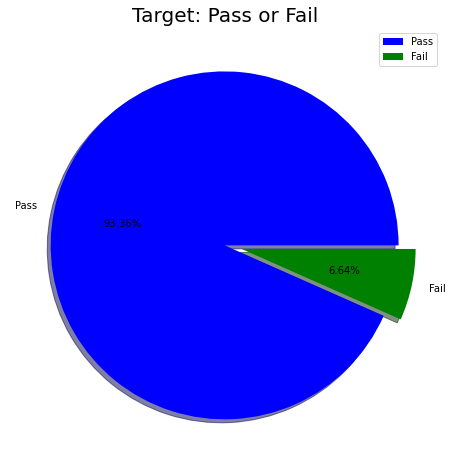

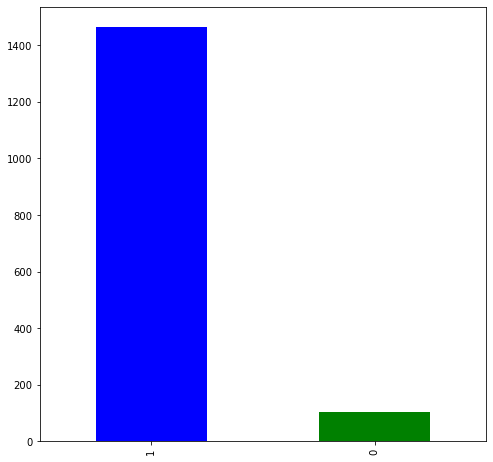

In [45]:
eController.imbalancedVisual(y)

# 2. Null Handling

## 2.1 Null Check

In [46]:
# missing value percentage
missingCol,dropCol = eController.checkNull(df=X_train,percent = 20)

# 20% 이상 NUll 값이 존재하면 drop 

missing 10~20%: 20개
missing 20~30%: 0개
missing 30~40%: 0개
missing 40~50%: 4개
missing 50~60%: 4개
missing 60~70%: 16개
missing 70~80%: 0개
missing 80~90%: 4개
missing 90~100%: 4개


In [47]:
# drop 
X_train = X_train.drop(dropCol,axis=1)
X_test = X_test.drop(dropCol,axis=1)
X_train.shape,X_test.shape

((1096, 558), (471, 558))

## 2.2 Fill Null value

### 2.2.1 KNN Imputer (App.1)

### 2.2.2 mean value

In [48]:
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
# mController.logisticEvaluate(X_train,X_test,y_train,y_test)


In [49]:
full_train = X_train
full_test = X_test

In [50]:
full_train.shape

(1096, 558)

## 1.2 Number of Unique Value

In [51]:
uniqueColWithNull = eController.checkUniqueValueColWithRawData(X_train,True)
len(uniqueColWithNull)

1 unique vaule: 116 개
1 unique vaule + null : 116 개


116

In [52]:
# unique vaule + null drop 
X_train = X_train.drop(uniqueColWithNull,axis=1)
X_test = X_test.drop(uniqueColWithNull,axis=1)
X_train.shape,X_test.shape
cleansed_train = X_train
cleansed_test = X_test


0      1071
1      1064
2       460
3       465
4       453
       ... 
585    1069
586     291
587     236
588     113
589     494
Length: 442, dtype: int64



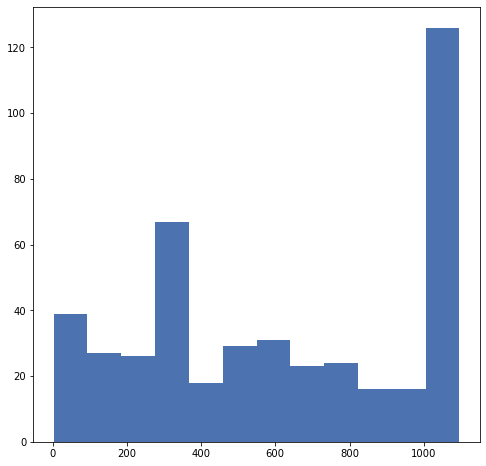

In [53]:
# unique value histogram
temp = pd.Series(X_train.nunique())
print(temp)
print()
plt.hist(temp,bins = 12,label='Num of Unique values')
plt.show()

### Drop Unique Val under 100


(1096, 401) (471, 401)


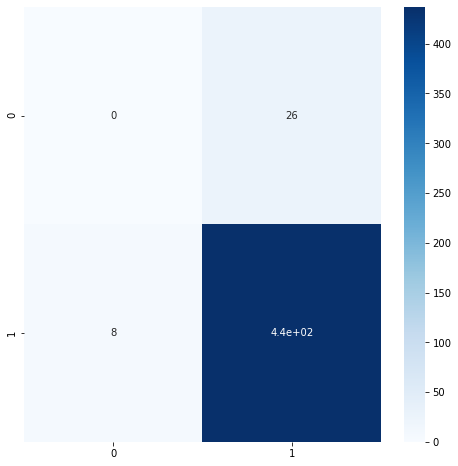

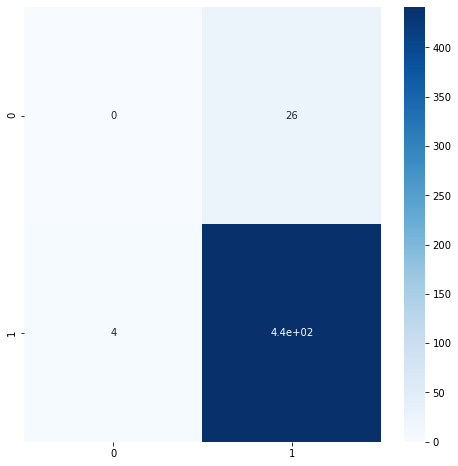

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.925182,0.927813,0.126523,-0.031773,1.0
RandomForest,0.962591,0.936306,0.675273,-0.022371,1.0


In [57]:
thCol = [i for i,val in X_train.nunique().iteritems() if val <=100]
X_train,X_test = pController.dropCol(X_train,X_test,thCol)
print(X_train.shape, X_test.shape)
a,b =mController.logisticEvaluate(X_train,X_test,y_train,y_test)
reduced_train = X_train
reduced_test = X_test

### Ranksum 2 test

In [58]:
ranksum_col = []
tempData = X_train.merge(y_train,left_index=True,right_index=True)
passData = tempData[tempData['Pass/Fail']==1]
failData = tempData[tempData['Pass/Fail']==0]
colList = list(X_train.columns)
for i in colList:
    pValue = stats.ranksums(passData[i],failData[i]).pvalue
    
    if pValue>0.05:
        ranksum_col. append(i)
print(len(ranksum_col)) 
X_train,X_test = pController.dropCol(X_train,X_test,ranksum_col)
t_train = X_train
t_test = X_test
X_train.shape,X_test.shape

340


((1096, 61), (471, 61))

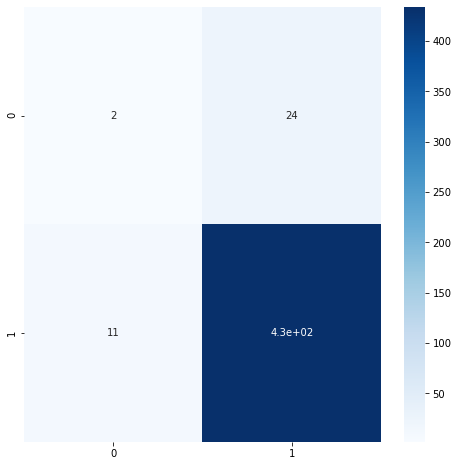

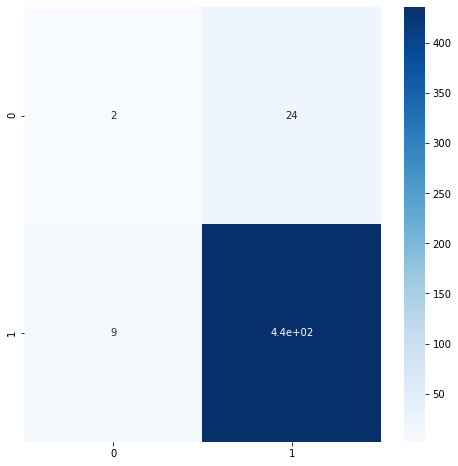

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.933394,0.925690,0.264689,0.072772,0.923077
RandomForest,0.979927,0.929936,0.838309,0.085736,0.923077


(   Logistic Regression RandomForest
 0                  341          341
 1                  348           21
 2                  205          163
 3                  428          102
 4                  163           59
 ..                 ...          ...
 56                 455           78
 57                 425          365
 58                 468          417
 59                 103          455
 60                  40          482
 
 [61 rows x 2 columns],
                      f1_train   f1_test  mcc_train  mcc_test       fpr
 Logistic Regression  0.933394  0.925690   0.264689  0.072772  0.923077
 RandomForest         0.979927  0.929936   0.838309  0.085736  0.923077)

In [60]:

mController.logisticEvaluate(X_train,X_test,y_train,y_test)

## 3. Multicollinearity (VIF)

In [61]:
#calculate Variance Inflation Factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
condition = 1
temp_train = X_train
vifDropCol = []
while condition !=0:

    vif_scores = pd.DataFrame() 

    vif_scores["Attribute"] = temp_train.columns 
    # calculating VIF for each feature 
    vif_scores["VIF Scores"] = [variance_inflation_factor(temp_train.values, i) for i in range(len(temp_train.columns))] 
    condition = (vif_scores['VIF Scores']>10).sum()
    droppingCol = vif_scores['Attribute'][vif_scores['VIF Scores'].idxmax()]
    vifDropCol.append(droppingCol)
    temp_train =temp_train.drop([droppingCol],axis=1)

display(vif_scores)

,Attribute,VIF Scores
0,40,7.531635
1,59,2.171068
2,78,1.320646
3,79,1.442758
4,102,1.034151
5,195,1.632336
6,200,5.636221
7,213,2.708707
8,227,3.964522
9,279,5.070504


In [62]:
X_train ,X_test= pController.dropCol(X_train,X_test,vifDropCol)
f_train,f_test = X_train,X_test

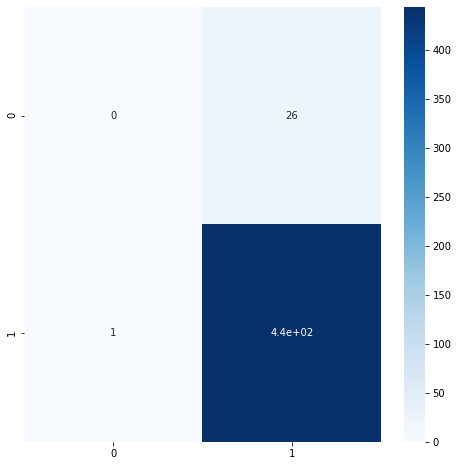

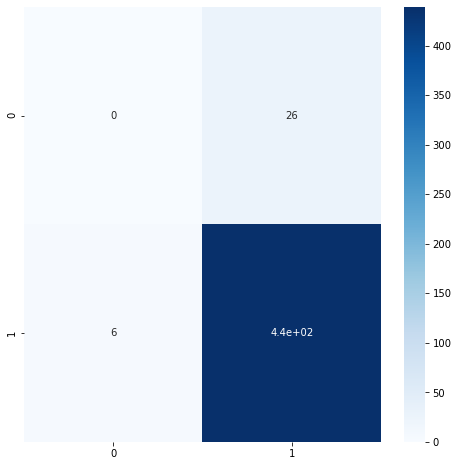

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.927920,0.942675,0.111451,-0.011150,1.0
RandomForest,0.972628,0.932059,0.772845,-0.027457,1.0


(   Logistic Regression RandomForest
 0                  511           59
 1                   59          102
 2                  482           78
 3                  102           40
 4                  348          477
 5                  510           79
 6                  587          425
 7                  388          348
 8                  200          468
 9                  460          510
 10                 428          200
 11                 227          388
 12                 279          511
 13                  79          434
 14                 477          213
 15                 213          428
 16                 468          460
 17                  78          195
 18                 195          227
 19                  40          482
 20                 425          587
 21                 434          279,
                      f1_train   f1_test  mcc_train  mcc_test  fpr
 Logistic Regression  0.927920  0.942675   0.111451 -0.011150  1.0
 RandomForest 

In [63]:
mController.logisticEvaluate(X_train,X_test,y_train,y_test)

In [64]:
sns.pairplot(temp_train)

In [65]:
sns.heatmap(temp_train)

## Oversampling (SMOTE)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1096, 22) (1096,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2036, 22) (2036,)
SMOTE 적용 후 레이블 값 분포: 
 1    1018
0    1018
Name: Pass/Fail, dtype: int64


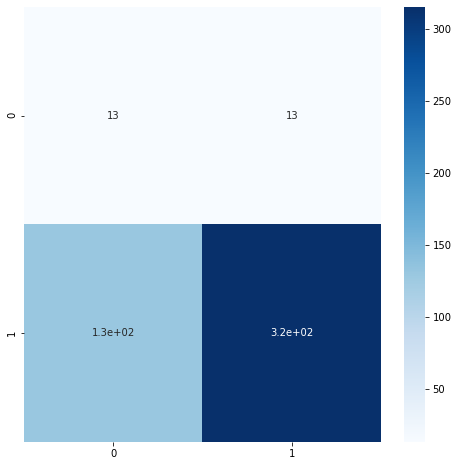

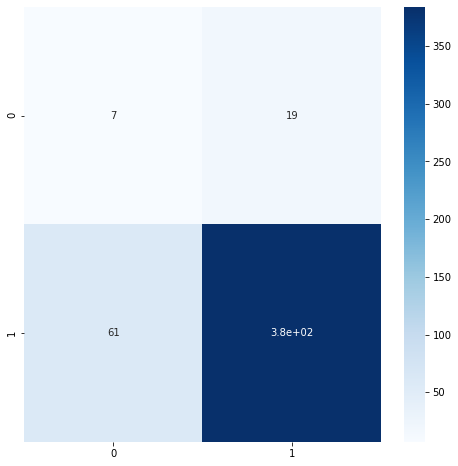

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.745088,0.696391,0.490188,0.103239,0.500000
RandomForest,0.984283,0.830149,0.968882,0.085868,0.730769


In [66]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
a,b = mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1096, 22) (1096,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2020, 22) (2020,)
SMOTE 적용 후 레이블 값 분포: 
 1    1018
0    1002
Name: Pass/Fail, dtype: int64


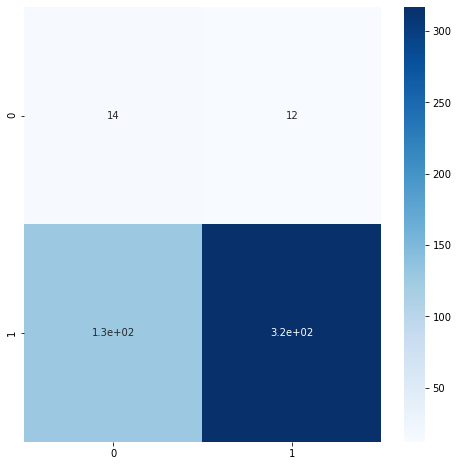

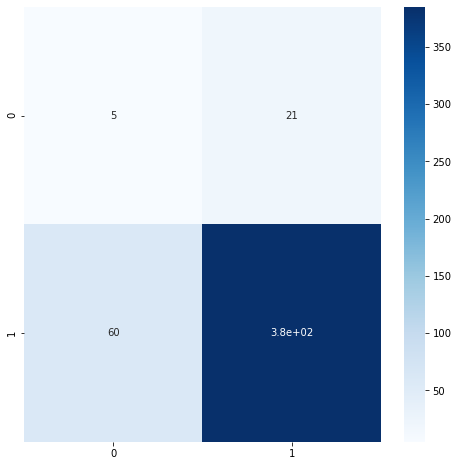

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.733663,0.702760,0.467276,0.124821,0.461538
RandomForest,0.984158,0.828025,0.968642,0.038057,0.807692


(   Logistic Regression RandomForest
 0                   59           59
 1                  511          388
 2                  102           40
 3                  200          200
 4                  482          428
 5                  348          213
 6                  510          460
 7                  388          477
 8                   79          348
 9                  468          511
 10                 213          102
 11                 477           79
 12                 227          468
 13                 428          434
 14                 279          587
 15                 460          510
 16                 587           78
 17                  78          195
 18                 195          425
 19                  40          279
 20                 425          482
 21                 434          227,
                      f1_train   f1_test  mcc_train  mcc_test       fpr
 Logistic Regression  0.733663  0.702760   0.467276  0.124821  0.461538
 Ran

In [67]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=22)
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1096, 22) (1096,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2018, 22) (2018,)
SMOTE 적용 후 레이블 값 분포: 
 1    1018
0    1000
Name: Pass/Fail, dtype: int64


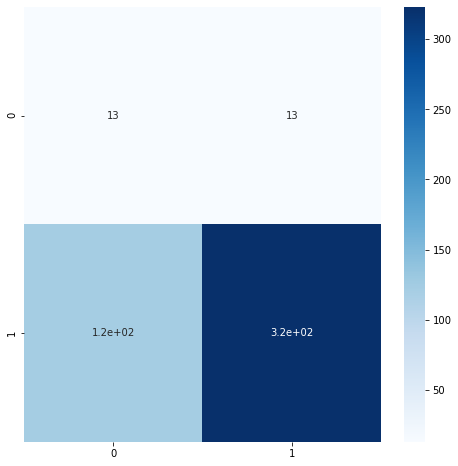

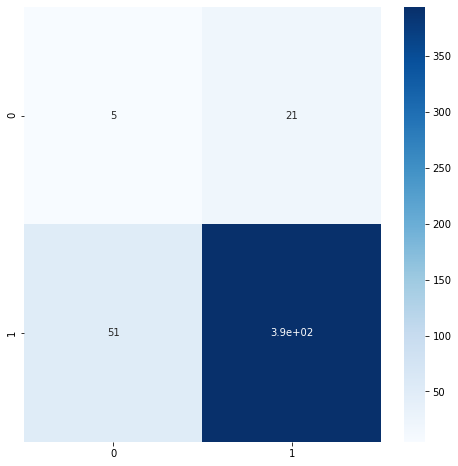

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.755203,0.713376,0.510402,0.114061,0.500000
RandomForest,0.988107,0.847134,0.976338,0.054825,0.807692


(   Logistic Regression RandomForest
 0                   59           59
 1                  511           40
 2                  482           79
 3                  102          477
 4                  200          425
 5                  348          428
 6                  510          460
 7                  388          348
 8                  468          587
 9                  460          388
 10                 227          468
 11                 428          511
 12                 213          434
 13                 477          213
 14                 587          195
 15                 279          227
 16                  79          279
 17                  78          200
 18                 195          482
 19                  40          102
 20                 425          510
 21                 434           78,
                      f1_train   f1_test  mcc_train  mcc_test       fpr
 Logistic Regression  0.755203  0.713376   0.510402  0.114061  0.500000
 Ran

In [68]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train_over,y_train_over = smoteto.fit_resample(X_train,y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1096, 22) (1096,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (2036, 22) (2036,)
SMOTE 적용 후 레이블 값 분포: 
 1    1018
0    1018
Name: Pass/Fail, dtype: int64


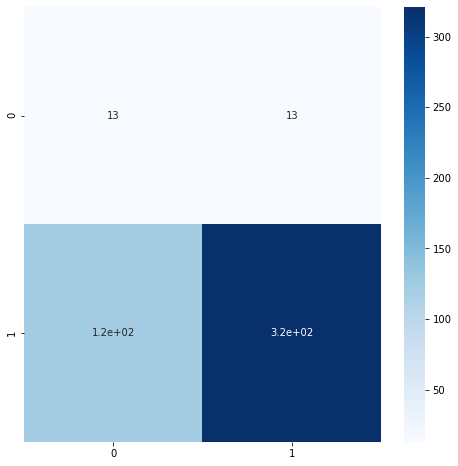

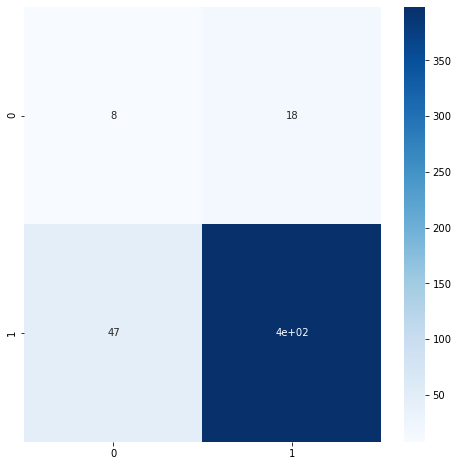

,f1_train,f1_test,mcc_train,mcc_test,fpr
Logistic Regression,0.760806,0.709130,0.521994,0.111304,0.500000
RandomForest,0.987721,0.861996,0.975522,0.143698,0.692308


(   Logistic Regression RandomForest
 0                  511           79
 1                   59          468
 2                  482          460
 3                  468          477
 4                  348           59
 5                  102          425
 6                  510           40
 7                  200          511
 8                  279          213
 9                  213          428
 10                 428           78
 11                 477          434
 12                  79          102
 13                 460          279
 14                  78          348
 15                 388          388
 16                 587          200
 17                 425          587
 18                 227          227
 19                 195          510
 20                 434          195
 21                  40          482,
                      f1_train   f1_test  mcc_train  mcc_test       fpr
 Logistic Regression  0.760806  0.709130   0.521994  0.111304  0.500000
 Ran

In [69]:
from imblearn.over_sampling import BorderlineSMOTE
X_train_over, y_train_over = BorderlineSMOTE().fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())
mController.logisticEvaluate(X_train_over,X_test,y_train_over,y_test)